In [1]:
import numpy
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
g = torch.Generator().manual_seed(2147483647)
perm = torch.randperm(len(words), generator=g)

n = len(words)
n_train = int(0.8 * n)
n_dev = int(0.1 * n)

train_words = [words[i] for i in perm[:n_train]]
dev_words = [words[i] for i in perm[n_train:n_train + n_dev]]
test_words = [words[i] for i in perm[n_train + n_dev:]]

In [4]:
chars = sorted(list(set(''.join(words))))
ctoi = {c: i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
N = torch.zeros((27, 27), dtype=torch.int32)
itoc = {i: c for c, i in ctoi.items()}

In [5]:
for w in train_words:
    chs = list(f".{w}.")
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch2]
        N[ix1, ix2] += 1

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

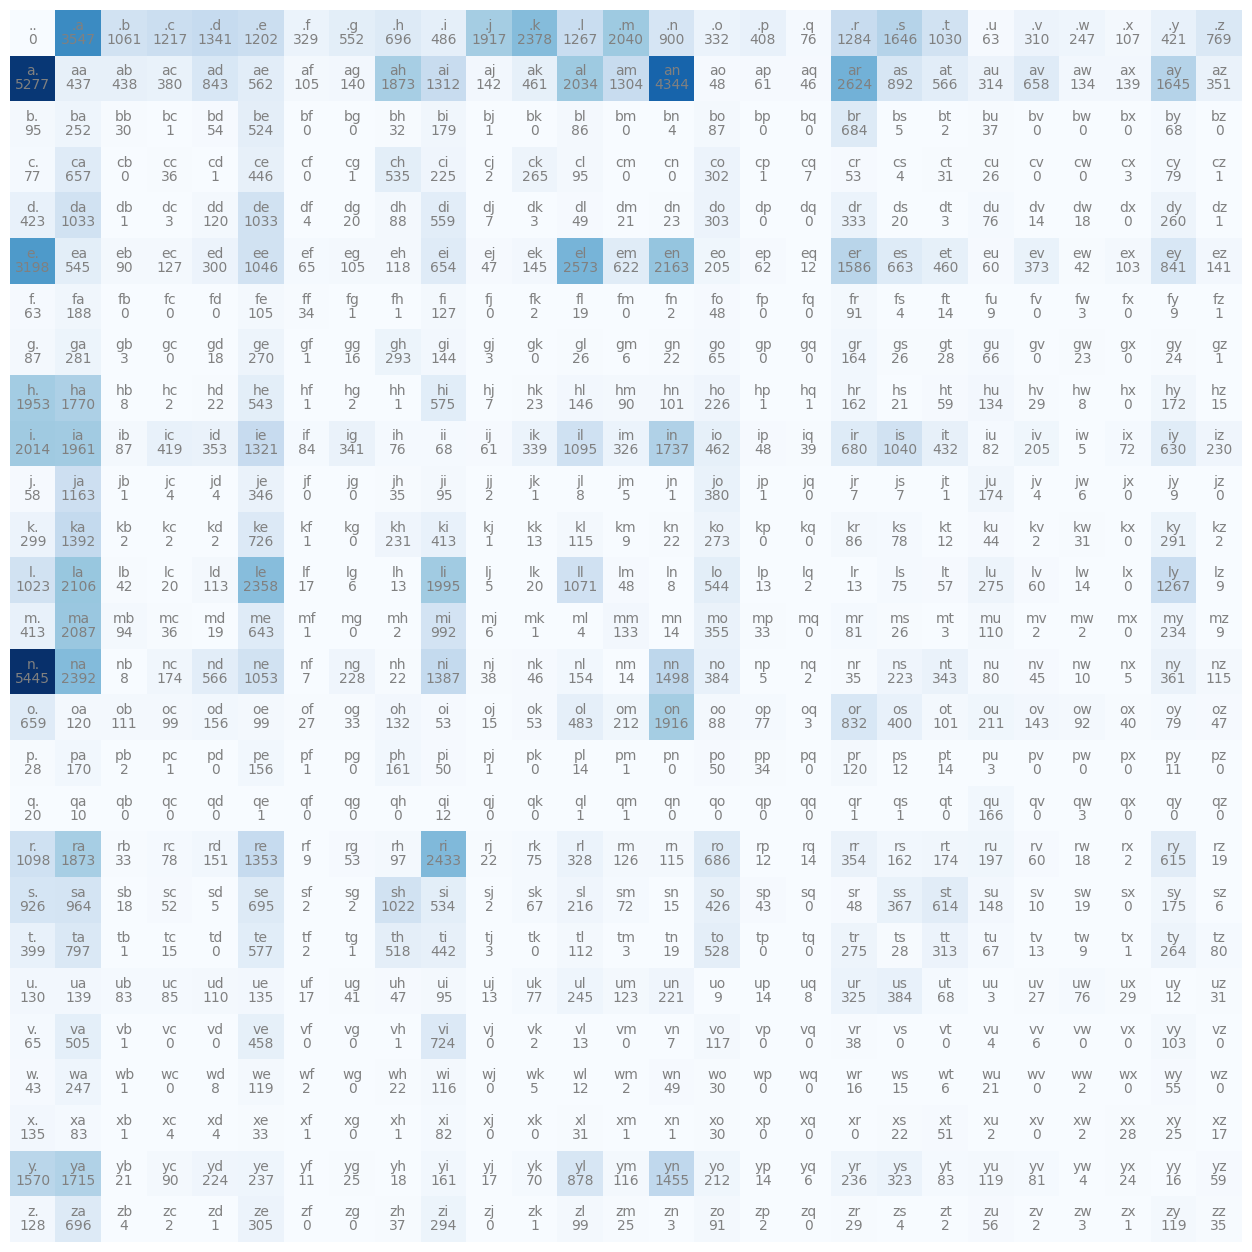

In [6]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')

for i in range(27):
    for j in range(27):
        chstr = itoc[i] + itoc[j] # concat the letters itoc[i] and itoc[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray') # print the concatenated letters
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color='gray') # print the value of the N[i,j]
plt.axis('off')

In [7]:
P = (N+1).float()
P /= P.sum(1, keepdim=True)

(np.float64(-0.5), np.float64(26.5), np.float64(26.5), np.float64(-0.5))

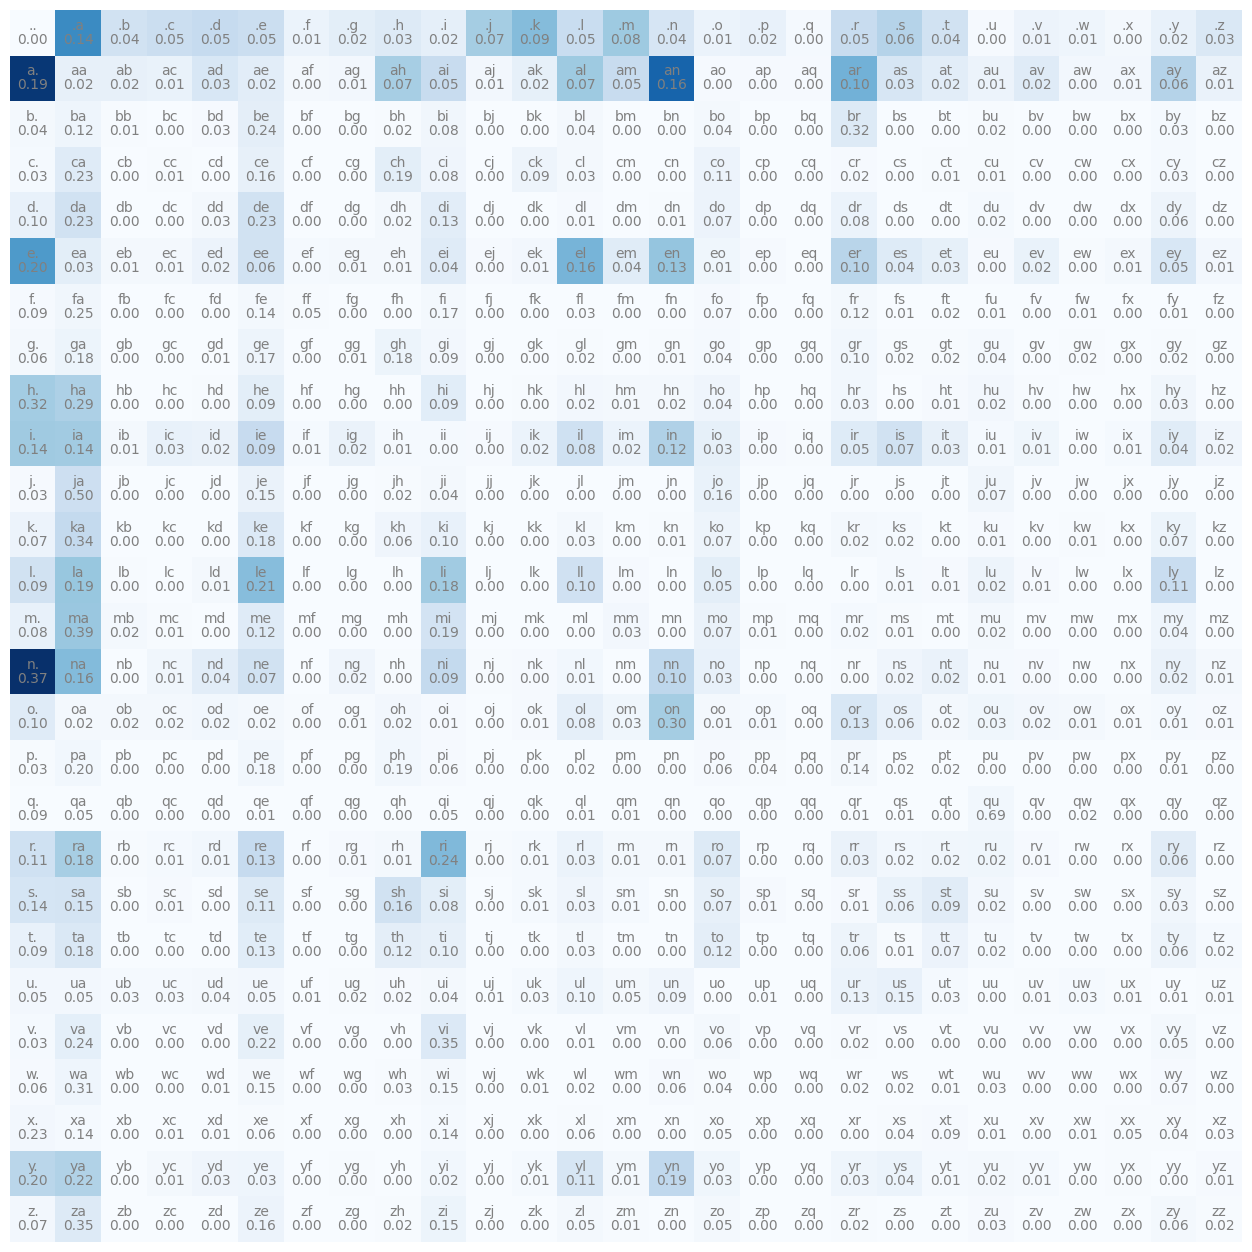

In [8]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')

for i in range(27):
    for j in range(27):
        chstr = itoc[i] + itoc[j] # concat the letters itoc[i] and itoc[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray') # print the concatenated letters
        plt.text(j, i, "{:.2f}".format(P[i,j].item()), ha="center", va="top", color='gray') # print the value of the N[i,j]
plt.axis('off')

In [9]:
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    out = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[ix])
        if ix == 0:
            break
    print("".join(out))

cexze.
momakurailezitynn.
konimittain.
llayn.
ka.


In [10]:
log_likelihood = 0.0
n = 0

for w in train_words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch2]
        prob = P[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n+=1

print(f"{log_likelihood=}")
nll = -log_likelihood
print(f"{nll=}")
print(f"{nll/n}")


log_likelihood=tensor(-448256.0625)
nll=tensor(448256.0625)
2.455080986022949


In [11]:
xs, ys = [], []
for word in train_words:
    chs = list(f".{word}.")
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(ctoi[ch1])
        ys.append(ctoi[ch2])

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f"Number of examples: {num}")

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

Number of examples: 182583


In [12]:
import torch.nn.functional as F

for k in range(300):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float() # Input to the network: one-hot encoding of the ctoi idx. dim: 1x27
    logits = xenc @ W # forward pass. dim: 1x27 @ 27x27 = 1x27
    counts = logits.exp() # counts
    probs = counts / counts.sum(1, keepdim=True) # probabilities for next char
    loss = -probs[torch.arange(num), ys].log().mean() 
    print(f"loss: {loss.item()}")

    #backward pass:
    W.grad = None # set zero to the current gradiant.
    loss.backward()
    # Update
    W.data += -10 * W.grad

loss: 3.7549567222595215
loss: 3.666532516479492


loss: 3.5876801013946533
loss: 3.5167813301086426
loss: 3.452779769897461
loss: 3.394904375076294
loss: 3.3425350189208984
loss: 3.2951271533966064
loss: 3.252169609069824
loss: 3.21317458152771
loss: 3.1776790618896484
loss: 3.1452550888061523
loss: 3.1155197620391846
loss: 3.088141441345215
loss: 3.0628395080566406
loss: 3.039377212524414
loss: 3.017556667327881
loss: 2.997210741043091
loss: 2.978199005126953
loss: 2.9603989124298096
loss: 2.94370436668396
loss: 2.9280221462249756
loss: 2.913268566131592
loss: 2.8993687629699707
loss: 2.8862547874450684
loss: 2.8738656044006348
loss: 2.8621439933776855
loss: 2.8510396480560303
loss: 2.840505838394165
loss: 2.8304994106292725
loss: 2.820981740951538
loss: 2.811917304992676
loss: 2.8032732009887695
loss: 2.7950198650360107
loss: 2.78713059425354
loss: 2.7795796394348145
loss: 2.7723448276519775
loss: 2.7654056549072266
loss: 2.758742570877075
loss: 2.7523388862609863
loss: 2.7461776733398438
loss: 2.7402451038360596
loss: 2.73452758789

In [13]:
def cross_entropy(logits, ys):
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdim=True)
    loss = -probs[torch.arange(ys.shape[0]), ys].log().mean()
    return loss

In [14]:
def make_bigram_tensors(words_list):
    xs, ys = [], []
    for word in words_list:
        chs = list(f".{word}.")
        for ch1, ch2 in zip(chs, chs[1:]):
            xs.append(ctoi[ch1])
            ys.append(ctoi[ch2])

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    return xs, ys

In [15]:
with torch.no_grad():
    x_dev, y_dev = make_bigram_tensors(dev_words)
    xenc = F.one_hot(x_dev, num_classes=27).float() 
    logits = xenc @ W
    dev_loss_nn = cross_entropy(logits, ys=y_dev)

    x_test, y_test = make_bigram_tensors(test_words)
    xenc = F.one_hot(x_test, num_classes=27).float() 
    logits = xenc @ W
    test_loss_nn = cross_entropy(logits, y_test)

    print(f"{test_loss_nn=}")
    print(f"{dev_loss_nn=}")


test_loss_nn=tensor(2.4873)
dev_loss_nn=tensor(2.4893)


In [ ]:
def bigram_counting_nll(words_list, probs_table):
    log_likelihood, n = 0.0, 0
    for w in words_list:
        chs = list(f".{w}.")
        for ch1, ch2 in zip(chs, chs[1:]):
            ix1 = ctoi[ch1]
            ix2 = ctoi[ch2]
            log_likelihood += torch.log(probs_table[ix1,ix2])
            n+=1
    return -log_likelihood/n

In [ ]:
dev_loss_count = bigram_counting_nll(dev_words, P)
test_loss_count = bigram_counting_nll(test_words, P)
print(f"{dev_loss_count=}")
print(f"{test_loss_count=}")

dev_loss_count=tensor(2.4546)
test_loss_count=tensor(2.4554)
